<hr>
<p align="center">
  <b><font size="6">🧹✨ CLEANING TIME & PRICE PREDICTION USING XGBOOST✨🧹</font></b>
</p>
<hr>


This project predicts the total cleaning time based on
- number of bedrooms,
- number of bathrooms,
- type of job (standard or deep clean), and
- type of house (condo/townhouse or detached).


#### **1. Import Necessary Libraries**

In [1]:
# Import Necessary Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from xgboost import XGBRegressor, plot_importance
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.feature_selection import mutual_info_regression
import matplotlib.pyplot as plt

#### **2. Synthetic Dataset Generation**

In this section, we:

- Define cleaning time logic using lookup tables for bedrooms, bathrooms, job type, and house type.

- Create a function to estimate total cleaning time per record (calculate_total_time).

- Simulate a large dataset (e.g., 100,000 records) with:

  - Randomly chosen values for bedrooms, bathrooms, job type, and house type.

  - Calculated total cleaning time using our logic.

  - Final price computed using a fixed hourly rate.

- Store everything in a clean, structured pandas DataFrame.

##### 2.1 Lookup Tables for Time Estimation

This section explains the basic reference tables we use to estimate how long a cleaning job will take. These values are based on real-world knowledge and help us create a realistic dataset for our model.
- We use tables to assign cleaning time based on the number of bedrooms and bathrooms.

- We also add multipliers to adjust time depending on the type of job (standard or deep clean) and the type of house (condo or detached).

- These lookup tables help us calculate the total cleaning time for each house in a way that reflects real cleaning service scenarios.

In [2]:
# Lookup tables
bedroom_hours = {
    0: 0.5, 0.5: 0.5, 1: 0.5, 1.5: 0.75, 2: 1, 2.5: 1.25, 3: 1.5, 3.5: 1.75, 4: 2,
    4.5: 2.25, 5: 2.5, 5.5: 2.75, 6: 3, 6.5: 3.25, 7: 3.5, 7.5: 3.75, 8: 4,
    8.5: 4.25, 9: 4.5, 9.5: 4.75, 10: 5, 10.5: 5.25, 11: 5.5, 11.5: 5.75,
    12: 6, 12.5: 6.25, 13: 6.5, 13.5: 6.75, 14: 7, 14.5: 7.25, 15: 7.5,
    15.5: 7.75, 16: 8, 16.5: 8.25, 17: 8.5, 17.5: 8.75, 18: 9, 18.5: 9.25,
    19: 9.5, 19.5: 9.75, 20: 10, 20.5: 10.25, 21: 10.5
}

bathroom_hours = {
    1: 0.5, 1.5: 0.75, 2: 1, 2.5: 1.25, 3: 1.5, 3.5: 1.75, 4: 2, 4.5: 2.25,
    5: 2.5, 5.5: 2.75, 6: 3, 6.5: 3.25, 7: 3.5, 7.5: 3.75, 8: 4, 8.5: 4.25,
    9: 4.5, 9.5: 4.75, 10: 5, 10.5: 5.25, 11: 5.5, 11.5: 5.75, 12: 6
}

job_multipliers = {
    "standard_clean": 1.0,
    "deep_clean": 1.8
}

house_multipliers = {
    "Condo/Townhouse": 1.0,
    "Detached": 1.3
}

##### 2.2 Function to Calculate Cleaning Time

- Clean Time is calculated using number of bedrooms, bathrooms, job type and house type using the below formula:  
$$ total_time = (bedroom_time + bathroom_time) × job_multiplier × house_multiplier $$  
- If the result is less than 2.5, the function will return 2.5 instead.  

In [3]:
# Function to calculate time
def calculate_total_time(bedrooms, bathrooms, job_type, house_type):
    base_time = bedroom_hours.get(bedrooms, 0) + bathroom_hours.get(bathrooms, 0)
    adjusted_time = round(base_time * job_multipliers.get(job_type, 1.0) * house_multipliers.get(house_type, 1.0),2)
    return max(adjusted_time, 2.5)

##### 2.3 Function to Generate Synthetic Dataset

This function creates a synthetic dataset that mimics real-world cleaning service requests.  

In [4]:
# Generate dataset
def generate_data(n=3000):
    data = []
    for _ in range(n):
        # Randomly select a number of bedrooms
        bedrooms = np.random.choice([1, 2, 3, 4, 5])

        # Determine the corresponding bathroom count
        if bedrooms == 1:
            bathrooms = np.random.choice([1, 1.5])
        elif bedrooms == 2:
            bathrooms = np.random.choice([1.5, 2])
        elif bedrooms == 3:
            bathrooms = np.random.choice([2, 2.5, 3])
        elif bedrooms == 4:
            bathrooms = np.random.choice([3, 3.5, 4])
        else:
            bathrooms = np.random.choice([4, 4.5])
        job_type = np.random.choice(list(job_multipliers.keys()))
        house_type = np.random.choice(list(house_multipliers.keys()))
        total_time = calculate_total_time(bedrooms, bathrooms, job_type, house_type)
        price = round(total_time * 35, 2)
        data.append([bedrooms, bathrooms, job_type, house_type, total_time, price])
    return pd.DataFrame(data, columns=["bedrooms", "bathrooms", "job_type", "house_type", "total_time", "price"])

df = generate_data(100000)
df.head()

,bedrooms,bathrooms,job_type,house_type,total_time,price
0,4,3.0,deep_clean,Detached,8.19,286.65
1,3,3.0,deep_clean,Detached,7.02,245.70
2,5,4.0,deep_clean,Condo/Townhouse,8.10,283.50
3,3,3.0,standard_clean,Detached,3.90,136.50
4,3,3.0,standard_clean,Detached,3.90,136.50


##### 2.4 Feature Selection using Mutual Information

- In this section, we focus on selecting the most useful features for our model using Mutual Information Regression to check how strongly each feature is related to the target.
- We sort the scores and remove features with very low values (threshold < 0.01) as they don’t add much value to the model.

In [5]:
# Mutual Information Filter for Feature Importance
X_mi = df.drop(columns=["total_time", "price"])
y_mi = df["total_time"]
X_encoded = pd.get_dummies(X_mi, drop_first=True)
mi_scores = mutual_info_regression(X_encoded, y_mi)
mi_series = pd.Series(mi_scores, index=X_encoded.columns).sort_values(ascending=False)
mi_series

bathrooms                  1.684375
bedrooms                   1.338879
house_type_Detached        0.514310
job_type_standard_clean    0.478480
dtype: float64

All features have decent MI scores, hence we kept all of them.

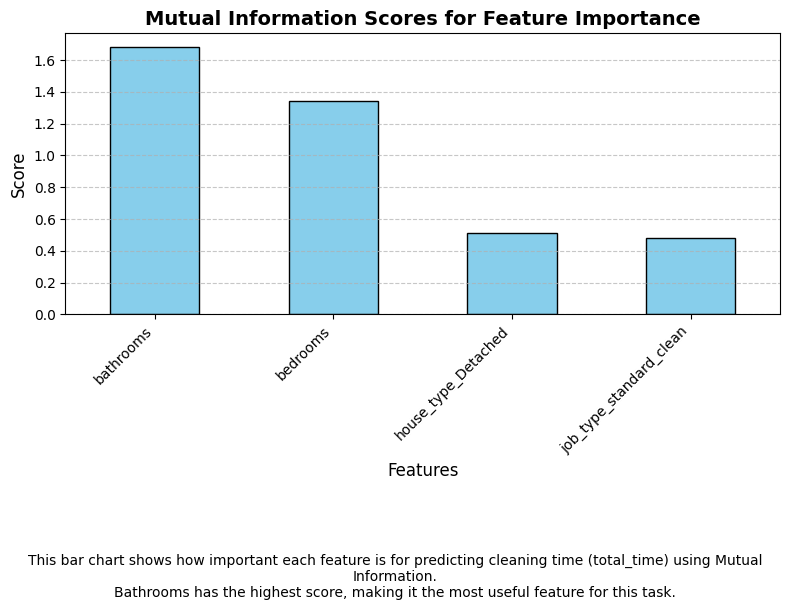

In [6]:
plt.figure(figsize=(8, 5))

mi_series.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Mutual Information Scores for Feature Importance', fontsize=14, weight='bold')
plt.ylabel('Score', fontsize=12)
plt.xlabel('Features', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)


plt.figtext(
    0.5, -0.2,
    "This bar chart shows how important each feature is for predicting cleaning time (total_time) using Mutual Information.\n"
    "Bathrooms has the highest score, making it the most useful feature for this task.",
    wrap=True, horizontalalignment='center', fontsize=10
)
plt.tight_layout()
plt.show()


#### **3. Model Training and Evaluation with XGBoost**

- In this section, we use the filtered features to train an XGBoost Regressor.
- We perform a grid search to find the best combination of hyperparameters.
- The model is then evaluated on the test set using metrics like Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), and R² Score.

In [7]:
# Reconstruct X and y for modeling with filtered features
X = X_encoded
y = df["total_time"]

In [8]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
# Fit XGBoost directly on encoded and filtered features
model = XGBRegressor(objective="reg:squarederror", random_state=42)
param_grid = {
    "n_estimators": [100],
    "max_depth": [3, 4],
    "learning_rate": [0.05, 0.1]
}

grid_search = GridSearchCV(model, param_grid, cv=3, scoring="neg_mean_absolute_error")
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100}


In [10]:
# Evaluation
y_pred = best_model.predict(X_test)
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R²:", r2_score(y_test, y_pred))

MAE: 0.012364701670169773
RMSE: 0.022549222697049374
R²: 0.999909537382311


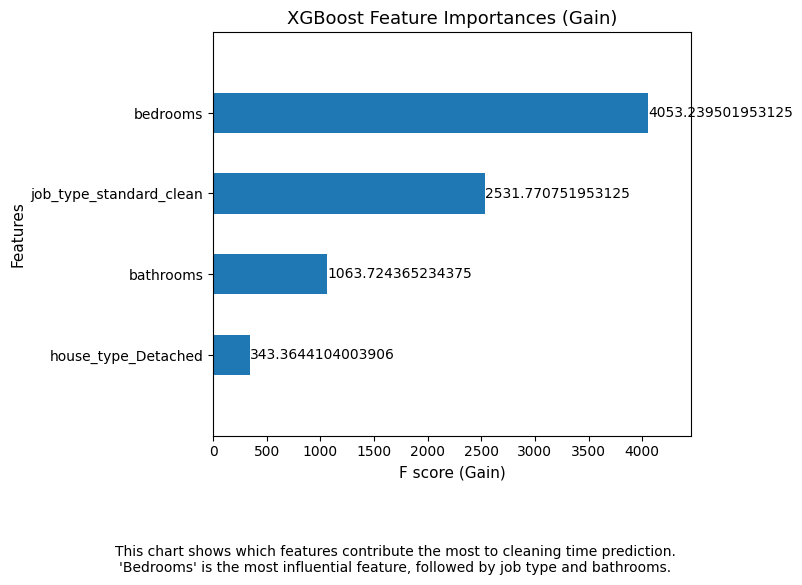

In [20]:
fig, ax = plt.subplots(figsize=(8, 5))

# Plot feature importances with rounded values
plot_importance(
    best_model,
    ax=ax,
    importance_type='gain',
    show_values=True,
    height=0.5,
    grid=False,
    max_num_features=10
)

# Set labels and title
ax.set_title("XGBoost Feature Importances (Gain)", fontsize=13)
ax.set_xlabel("F score (Gain)", fontsize=11)
ax.set_ylabel("Features", fontsize=11)

# Add a clean caption
caption = ("This chart shows which features contribute the most to cleaning time prediction.\n"
           "'Bedrooms' is the most influential feature, followed by job type and bathrooms.")
plt.figtext(0.5, -0.15, caption, wrap=True, ha='center', fontsize=10)

plt.tight_layout()
plt.show()


#### 4. Price Prediction on Unseen Data

In [24]:
# Predict on training data
y_train_pred = best_model.predict(X_train)

# Evaluation metrics
print("TRAINING DATA EVALUATION:")
print("MAE:", mean_absolute_error(y_train, y_train_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_train, y_train_pred)))
print("R²:", r2_score(y_train, y_train_pred))


TRAINING DATA EVALUATION:
MAE: 0.012483217034101428
RMSE: 0.022660084342580187
R²: 0.9999089548006289


In [21]:
y_pred = best_model.predict(X_test)

In [22]:
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R²:", r2_score(y_test, y_pred))


MAE: 0.012364701670169773
RMSE: 0.022549222697049374
R²: 0.999909537382311


##### Model Performance Summary

| **Metric**      | **Training Set** | **Test Set** | **Difference**   |
|-----------------|------------------|--------------|------------------|
| **MAE**         | 0.01248 hrs       | 0.01236 hrs   | ~0.0001          |
| **RMSE**        | 0.02266 hrs       | 0.02255 hrs   | ~0.0001          |
| **R² Score**    | 0.99991           | 0.99991       | negligible       |


- Training and test metrics are nearly identical. This confirms the model is not overfitting, and it generalizes exceptionally well.

- Passed unseen inputs through the trained XGBoost pipeline.
- Predicted `total_time` was rounded to the nearest 0.5 hour.
- Prices were calculated for **economy**, **standard**, and **premium** tiers.
- Each tier uses a different hourly rate (economy: $27, standard: $30, premium: $37).

In [15]:
# --- Unseen Data Inference ---

# Define new unseen input
unseen_data = pd.DataFrame({
    "bedrooms": [6, 2],
    "bathrooms": [4, 1.5],
    "job_type": ["deep_clean", "deep_clean"],
    "house_type": ['Condo/Townhouse', 'Detached']
})

# One-hot encode unseen data and align with training features
unseen_encoded = pd.get_dummies(unseen_data, drop_first=True)
unseen_encoded = unseen_encoded.reindex(columns=X_train.columns, fill_value=0)

# Predict using the trained XGBoost model
y_unseen_pred = best_model.predict(unseen_encoded)

# Define rates
economy_rate = 27
standard_rate = 30
premium_rate = 37

# Rounding function
def round_to_nearest_half_hour(t):
    return np.ceil(t * 2) / 2

# Price range function
def calculate_price_range(time, service):
    rate = {'economy': economy_rate, 'standard': standard_rate, 'premium': premium_rate}[service]
    rounded = round_to_nearest_half_hour(time)
    return (rounded - 0.5) * rate, rounded * rate


In [16]:
for i, time in enumerate(y_unseen_pred):
    print(f"\nUnseen Input {i+1} (Predicted time: {time:.2f} hrs)")
    for service in ['economy', 'standard', 'premium']:
        lower, upper = calculate_price_range(time, service)
        print(f"{service.title()} Price Range: ${lower:.2f} - ${upper:.2f}")



Unseen Input 1 (Predicted time: 8.10 hrs)
Economy Price Range: $216.00 - $229.50
Standard Price Range: $240.00 - $255.00
Premium Price Range: $296.00 - $314.50

Unseen Input 2 (Predicted time: 4.00 hrs)
Economy Price Range: $108.00 - $121.50
Standard Price Range: $120.00 - $135.00
Premium Price Range: $148.00 - $166.50


#### **Summary**

- The XGBoost model was trained on synthetic cleaning service data with features like bedrooms, bathrooms, job type, and house type.
- We used Mutual Information to select important features, then tuned the model with GridSearchCV.
- The model achieved excellent performance with R² ≈ 0.9999.
- On unseen data, we predicted the cleaning time and generated dynamic price ranges for different service tiers: economy, standard, and premium.
- This system is flexible and ready for deployment in real-world applications like booking platforms or service quote generators.


##### Saving the Model

In [ ]:
import joblib
import os

# Create a folder to save the files
os.makedirs("model", exist_ok=True)

# Save the trained model
joblib.dump(best_model, "model/model.pkl")

# Save the columns used for prediction (important for Flask input alignment)
joblib.dump(X_train.columns.tolist(), "model/columns.pkl")

✅ Model and column names saved successfully!
